In [172]:
from PIL import Image
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

GAMEPLAY_START_Y = 56
VIEWPORT_SIZE = 128

def show_image(tensor, grayscale=False, normalize=True):
    np_img = tensor.cpu().numpy()
    print(np_img.shape)
    if np_img.shape[0] == 1:
        np_img = np_img[0]
    elif np_img.shape[0] == 3:
        np_img = np_img.transpose(1, 2, 0)

    if grayscale:
        plt.imshow(np_img, cmap='gray')
    else:
        plt.imshow(np_img)
    plt.axis('off')
    plt.show()

link_pos = 128, 221

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
original = Image.open("screenshot.png")
obs = np.array(original)
frame = torch.from_numpy(obs).to(device)

(224, 240, 3)


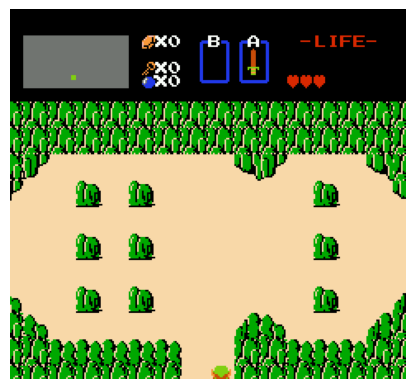

In [173]:
# normalize
norm = frame / 255.0
show_image(norm)

(3, 224, 240)


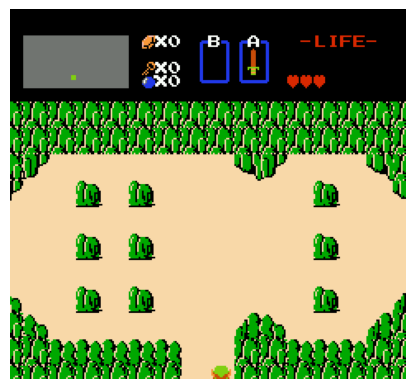

In [174]:
# fix shape

permuted = norm.permute(2, 0, 1)
permuted.shape
show_image(permuted)

(3, 168, 240)


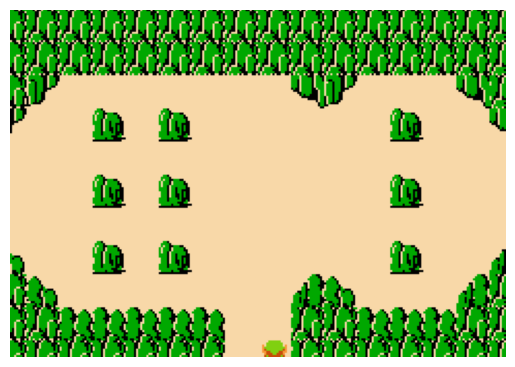

In [175]:
# Trim image
trimmed = permuted[:, GAMEPLAY_START_Y:, :]
show_image(trimmed)

(1, 168, 240)


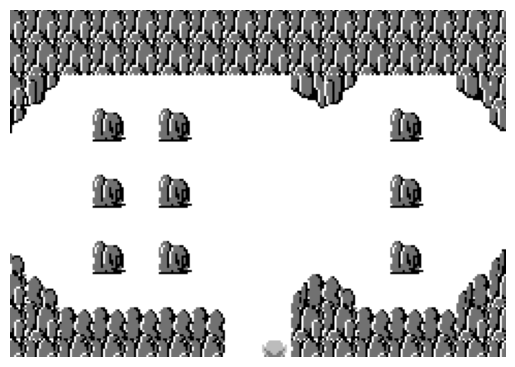

In [176]:
# to grayscale
GRAYSCALE_WEIGHTS = torch.FloatTensor([0.2989, 0.5870, 0.1140]).to(device)
grayscale = torch.tensordot(trimmed, GRAYSCALE_WEIGHTS, dims=([0], [0]))
grayscale = grayscale.unsqueeze(0)
show_image(grayscale, grayscale=True)

center: 128, 165
frame: w:240, h:229
bottom: 165 + 64 = 229 > 229
pad: 0 0 0 0
(1, 128, 128)


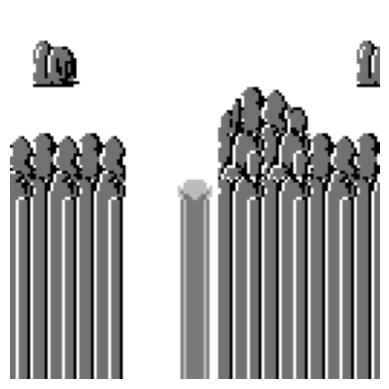

In [180]:
half_vp = VIEWPORT_SIZE // 2
x, y = link_pos
y -= GAMEPLAY_START_Y

print(f"center: {x}, {y}")

frame_width, frame_height = grayscale.shape[2], grayscale.shape[1]
print(f"frame: w:{frame_width}, h:{frame_height}")

print(f"bottom: {y} + {half_vp} = {y + half_vp} > {frame_height}")


# Check if padding is necessary
pad_top = max(0, half_vp - y)
pad_bottom = max(0, y + half_vp - frame_height)
pad_left = max(0, half_vp - x)
pad_right = max(0, x + half_vp - frame_width)

viewport = grayscale
if pad_top > 0 or pad_bottom > 0 or pad_left > 0 or pad_right > 0:
    viewport = F.pad(viewport, (pad_left, pad_right, pad_top, pad_bottom), mode='replicate')
    show_image(grayscale, grayscale=True)

print(f"pad: {pad_top} {pad_bottom} {pad_left} {pad_right}")

y += pad_top
x += pad_left

# Extract the viewport
viewport = viewport[:, y - half_vp:y + half_vp, x - half_vp:x + half_vp]
show_image(viewport, grayscale=True)
